<a href="https://colab.research.google.com/github/darkosisak/WQU-Group12-Capstone/blob/master/Capstone_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **An Event-based Short-term Trading Model**

The following represents the actionable Python code used in the Capstone Project.

Acknowledgements: Hudson & Thames (Jaques Joubert), Decisive Alpha (Lionel Young)


In [0]:
# run this cell if in Colaboratory
!pip install pyfolio
!pip install yfinance
!pip install mlfinlab
!pip install decisiveml

In [0]:
%reset -f

#0. Importing packages and libraries

In [1]:
#pip install -r requirements.txt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pyfolio as pf
import mlfinlab as ml

# trendscanning
import sys
sys.path.append("..")
import decisiveml as dml

from numpy import array

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, roc_auc_score

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from mlfinlab.filters import filters
from mlfinlab.labeling import labeling
#from mlfinlab.util import utils                        # deprecated

from mlfinlab.sampling import concurrent
from mlfinlab.sampling import bootstrapping
from mlfinlab.util import multiprocess

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive
from IPython.display import display

import yfinance as yf

from tqdm import tqdm_notebook as tqdm

% matplotlib inline

/usr/local/lib/python3.6/dist-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


#1. Loading data, generating features and signals

Here we build the event-based signals described in chapter 3.2 and features for the meta labeling

In [2]:
# loading data
r = pd.read_csv('https://capital20.com/WQU_CapstoneData/GBPUSD_TickBar_500_Bid_2019.01.02_2020.05.13.csv')

r.index = pd.to_datetime(r['Time (UTC)'])
r = r.drop(['Time (UTC)', 'EndTime'], axis=1)
prices = r["Close"] 

###############################################################################
# Features 1: Technical indicators
###############################################################################

def moving_average(x, n, type='simple'):
    """
    computing an n period moving average.
    type is 'simple' | 'exponential'
    """
    x = np.asarray(x)
    if type == 'exponential':
        weights = np.ones(n)
    else:
        weights = np.exp(np.linspace(-1., 0., n))

    weights /= weights.sum()

    a = np.convolve(x, weights, mode='full')[:len(x)]
    a[:n] = a[n]
    return a

def relative_strength(prices, n=14):
    """
    computing the n period relative strength indicator
    http://stockcharts.com/school/doku.php?id=chart_school:glossary_r#relativestrengthindex
    http://www.investopedia.com/terms/r/rsi.asp
    """

    deltas = np.diff(prices)
    seed = deltas[:n + 1]
    up = seed[seed >= 0].sum() / n
    down = -seed[seed < 0].sum() / n
    rs = up / down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100. / (1. + rs)

    for i in range(n, len(prices)):
        delta = deltas[i - 1]  # because the diff is 1 shorter!

        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up * (n - 1) + upval) / n
        down = (down * (n - 1) + downval) / n

        rs = up / down
        rsi[i] = 100. - 100. / (1. + rs)
    return rsi


def moving_average_convergence(x, nslow, nfast):
    """
    computing the MACD (Moving Average Convergence/Divergence) using a fast and
    slow exponential moving avg
    return value is emaslow, emafast, macd which are len(x) arrays
    """
    emaslow = moving_average(x, nslow, type='exponential')
    emafast = moving_average(x, nfast, type='exponential')
    return emaslow, emafast, emafast - emaslow


def bbands(close_prices, window, no_of_stdev):
    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band


def wwma(values, n):
    """
     J. Welles Wilder's EMA 
    """
    return values.ewm(alpha=1/n, adjust=False).mean()

def atr(df, n=14):
    data = r.copy()
    high = r['High']
    low = r['Low']
    close = r['Close']
    data['tr0'] = abs(high - low)
    data['tr1'] = abs(high - close.shift())
    data['tr2'] = abs(low - close.shift())
    tr = data[['tr0', 'tr1', 'tr2']].max(axis=1)
    atr = wwma(tr, n)
    atrx = atr*2
    return atr, atrx
  
# computing RSI
r['rsi'] = relative_strength(r['Close'], 14)

# computing BB
r['BBmid'], r['BBup'], r['BBlo'] = bbands(r['Close'], 20, no_of_stdev=2)

# computing the MACD indicator
nslow = 48
nfast = 26
nema = 20
emaslow, emafast, macd = moving_average_convergence(prices, nslow=nslow, nfast=nfast)
r['MACD'] = macd
r['MACD_sig'] = moving_average(r['MACD'], nema, type='exponential')

# computing the MAs
ma20 = moving_average(prices, 25, type='simple')
ma60 = moving_average(prices, 130, type='exponential')
ma200 = moving_average(prices, 200, type='simple')

# computing the ATRs
r['ATR'], r['ATRx'] = (atr(r['Close'], 7))

###############################################################################
# Signalling
###############################################################################

#### ATR DIRECTION
r['atr_dir'] = 0 
short_atr_dir = ((r['Close'] <= (r['Close'].shift(1) + r['ATRx'])) & (r['Close'].shift(1) > (r['Close'].shift(2) + r['ATRx'])))
long_atr_dir = ((r['Close'] > (r['Close'].shift(1) - r['ATRx'])) & (r['Close'].shift(1) <= (r['Close'].shift(2) - r['ATRx'])))
r.loc[long_atr_dir, 'atr_dir'] = 1
r.loc[short_atr_dir, 'atr_dir'] = -1

#### MICRO-BREAKOUT
r['mbo'] = 0 
long_mbo = (r['High'] > r['High'].shift(1))
short_mbo = (r['Low'] < r['Low'].shift(1)) 
r.loc[long_mbo, 'mbo'] = 1
r.loc[short_mbo, 'mbo'] = -1
"""
#### RETRACEMENT
r['rtm'] = np.nan 
long_rtm = ((r['Low'].shift(1) < r['BBmid'].shift(1)) &  (ma20 > ma60))  
short_rtm = ((r['High'].shift(1) > r['BBmid'].shift(1)) & (ma20 <= ma60)) 
r.loc[long_rtm, 'rtm'] = 1
r.loc[short_rtm, 'rtm'] = -1

#### BOUNCE
r['bou'] = np.nan 
long_bou = ((r['Close'] > r['Open']) & (ma20 > ma60))  
short_bou = ((r['Close'] < r['Open']) & (ma20 <= ma60)) 
r.loc[long_bou, 'bou'] = 1
r.loc[short_bou, 'bou'] = -1
"""
#### RETRACEMENT BOUNCE
r['rbo'] = np.nan           # not = 0, because we want to filter out all non-events to implement intrinsic time
long_rbo = ((r['Low'].shift(1) < r['BBmid'].shift(1)) & (r['Close'] > r['Open']) & (ma20 > ma60))  
short_rbo = ((r['High'].shift(1) > r['BBmid'].shift(1)) & (r['Close'] < r['Open']) & (ma20 <= ma60)) 
r.loc[long_rbo, 'rbo'] = 1
r.loc[short_rbo, 'rbo'] = -1

##### SIDES
r['BB_sides'] = 0 
long_signals = (r['Close'] <= r['BBlo']) 
short_signals = (r['Close'] >= r['BBup']) 
r.loc[long_signals, 'BB_sides'] = 1
r.loc[short_signals, 'BB_sides'] = -1

#### MA SIDE
r['dir'] = 0 
short_dir = (ma20 <= ma60) 
long_dir = (ma20 > ma60) 
r.loc[long_dir, 'dir'] = 1
r.loc[short_dir, 'dir'] = -1

#### OVERSOLD/OVERBOUGHT
r['over'] = 0 
oversold = (r['rsi'] <= 30) 
overbought = (r['rsi'] >= 70) 
r.loc[overbought, 'over'] = 1
r.loc[oversold, 'over'] = -1

#### BB STRETCH
r['BB_vol'] = 0 
not_oversold = (r['Close'] >= r['BBlo']) 
not_overbought = (r['Close'] <= r['BBup']) 
r.loc[not_oversold, 'BB_vol'] = -1
r.loc[not_overbought, 'BB_vol'] = 1

#### MACD MOMENTUM
r['MACD_mom'] = 0 
down = (r['MACD'] <= r['MACD_sig']) 
up = (r['MACD'] > r['MACD_sig']) 
r.loc[up, 'MACD_mom'] = 1
r.loc[down, 'MACD_mom'] = -1

# Remove Look ahead bias by lagging the signal
r['dir'] = r['dir'].shift(1)
r['atr_dir'] = r['atr_dir'].shift(1)
r['rbo'] = r['rbo'].shift(1)
r['over'] = r['over'].shift(1)
r['MACD_mom'] = r['MACD_mom'].shift(1)
r['BB_vol'] = r['BB_vol'].shift(1)
r['BB_sides'] = r['BB_sides'].shift(1)

print("ATR Direction:")
print(r.atr_dir.value_counts())
print("\n MA Direction:")
print(r.dir.value_counts())
print("\n Retracement Bounces:")
print(r.rbo.value_counts())
print("\n Micro-Breakouts:")
print(r.mbo.value_counts())
print("\n Oversold/overbought:")
print(r.over.value_counts())
print("\n BB Volatility:")
print(r.BB_vol.value_counts())
print("\n MACD momentum:")
print(r.MACD_mom.value_counts())
print("\n BB Sides:")
print(r.BB_sides.value_counts())


ATR Direction:
 0.0    86708
 1.0      162
-1.0      155
Name: atr_dir, dtype: int64

 MA Direction:
-1.0    44684
 1.0    42341
Name: dir, dtype: int64

 Retracement Bounces:
-1.0    13050
 1.0    12397
Name: rbo, dtype: int64

 Micro-Breakouts:
-1    41526
 1    33187
 0    12313
Name: mbo, dtype: int64

 Oversold/overbought:
 0.0    80346
-1.0     3367
 1.0     3312
Name: over, dtype: int64

 BB Volatility:
 1.0    86573
-1.0      451
 0.0        1
Name: BB_vol, dtype: int64

 MACD momentum:
-1.0    43579
 1.0    43446
Name: MACD_mom, dtype: int64

 BB Sides:
 0.0    86111
 1.0      463
-1.0      451
Name: BB_sides, dtype: int64


In [0]:
###############################################################################
# Features 2: More features
###############################################################################
# Log Returns
r['log_ret'] = np.log(r['Close']).diff()

# Momentum
r['mom1'] = r['Close'].pct_change(periods=1)

# Volatility
window_stdev = 50
r['vol_50'] = r['log_ret'].rolling(window=window_stdev, min_periods=window_stdev, center=False).std()

# Serial Correlation
window_autocorr = 50
r['autocorr_1'] = r['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)

# Backing up full features dataframe
r_bck = r.copy()

# 2. Event-based labeling for intrinsic time

The Trend Scanning technique is used here (see Chapter 3.2. for details) as a method to capture events for intrinsic time stored as separate labels under "trend".

In [0]:
##############################################################################
# Trend Scanning
###############################################################################
trend = dml.getBinsFromTrend(
    molecule=r["rbo"].dropna().index, 
    close=r.Close, 
    span=[22, 44, 11],)

r["trend"] = trend.bin 

# Labeling non-trends with 0
end = trend.t1
r.loc[end, "trend"] = 0
r.trend.fillna(method="ffill", inplace=True)
r.trend.fillna(0, inplace=True)

**Trend scanning visualisation on a time period snippet (optional)**

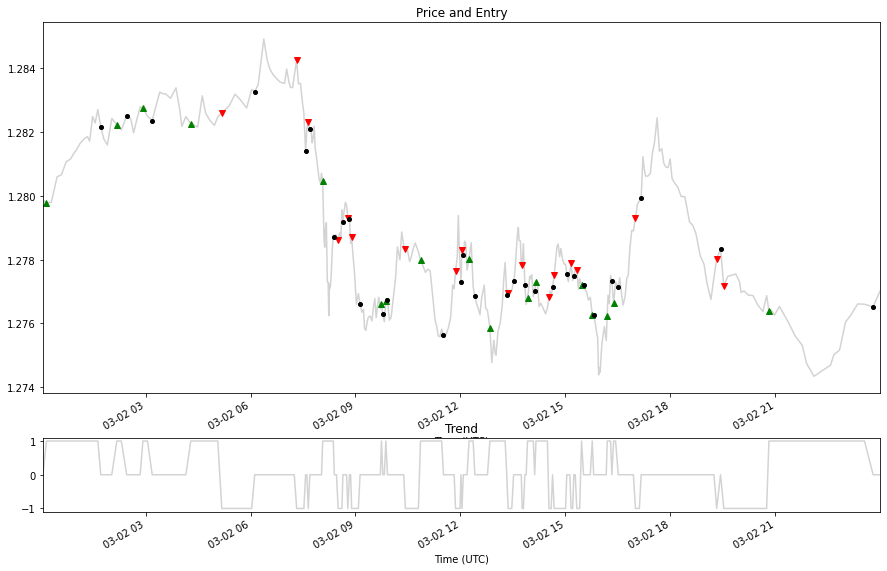

In [6]:
# Trend Scanning visualisation
#warnings.filterwarnings("ignore")            # optional, to get rid of the temporary matplotlib warning

fig, axes = plt.subplots(nrows=2, ncols=1, 
                         figsize=(15,10), 
                         gridspec_kw={'height_ratios': [5,1]})

rs = r['2020-03-02':'2020-03-02'].copy()      # picking one day only, for chart readability

# get the unfiltered trends
rs["trendlong"] = r[(r.trend == 1) & (r.trend.shift(1) != 1)].Close
rs["trendshort"] = r[(r.trend == -1) & (r.trend.shift(1) != -1)].Close
rs["trendend"] = r[(r.trend == 0) & (r.trend.shift(1) != 0)].Close

rs.Close.plot(ax=axes[0], color="lightgray")
rs.trendlong.plot(ax=axes[0], marker="^", markersize=6, color="green")
rs.trendshort.plot(ax=axes[0], marker="v", markersize=6, color="red")
rs.trendend.plot(ax=axes[0], marker="o", markersize=4, color="black")

rs.trend.plot(ax=axes[1], color="lightgray")

axes[0].title.set_text('Price and Entry')
axes[1].title.set_text('Trend')

#r.drop(['trendstart', 'trendend'], axis=1, inplace=True)

# 3. Machine Learning

This section deploys triple barrier labeling and machine learning. The *TBL_forecast* function splits the data into training and validation sets, performs TB labeling, compares metrics from the LR, SVC and RF classifiers and finally chooses and deploys the best classifier on the train and validations sets. The final train and validation ROC_AUC metrics are then plotted for possible overfitting identification.

The provided interactive widget enables the validation of different signals without the need to reload cells. Each time a new signal is chosen from the drop-down menu, the whole process reruns and updates the metrics for easy comparison and finding the best set-up. 

In [0]:
###############################################################################
# The Machine Learning Mega-function
###############################################################################
def TBL_forecast(signal):
  # Creating a separate set for TB labelling
  data = r.copy()
  data.dropna(axis=0, how='any', inplace=True)
  daily_vol = ml.util.get_daily_vol(close=data['Close'], lookback=50)       # the original idea from MLdP
  daily_vol2 = data['ATR']                                                  # Seems better in our case. Settings for ATR are in above section Features 1

  # applying Symmetric CUSUM Filter and getting timestamps for events given the daily volatility
  #cusum_events = filters.cusum_filter(data['Close'], threshold = daily_vol['2019-01-02':].mean()*0.04)     # the original idea from MLdP
  cusum_events = filters.cusum_filter(data['Close'], threshold = daily_vol2)                                # dynamic volatility, instead the original static mean

  # compute vertical barrier
  vertical_barriers = labeling.add_vertical_barrier(t_events = cusum_events, close=data['Close'], num_hours=6)

  pt_sl = [1, 2]
  min_ret = 0.0005 
  triple_barrier_events = labeling.get_events(close=data['Close'],
                                            t_events=cusum_events,
                                            pt_sl=pt_sl,
                                            target=daily_vol2,
                                            min_ret=min_ret,
                                            num_threads=3,
                                            vertical_barrier_times=False,                # to enable vertical barriers, put vertical_barriers
                                            side_prediction=data[signal])                # Here we choose one of the signals for the primary model 
  # labeling
  labels = ml.labeling.get_bins(triple_barrier_events, data['Close'])
  labels.side.value_counts()

  X = r.loc[labels.index, :]
  # dropping unwanted columns
  X.drop(['BBmid', 'BBup','BBlo','Open', 'over', 'BB_vol',
          'dir', #'atr_dir', 
          #'trend', 
          #'mbo',
          'MACD_mom',
          'High', 'Low', 'Close', 'ATRx', 'log_ret', 'rbo', 
          'MACD', 'rsi', 'vol_50', 'mom1', #'autocorr_1',
          #'mom2','mom3', 'mom4','mom5', 
          #'vol_13', 'vol_7', 'log_t2', 'log_t3', 'log_t4', 'log_t5',
          'MACD_sig'], axis=1, inplace=True)
  y = labels['bin']

  # splitting data into training and validation (test) sets
  X_training_validation = X['2019-01-02':'2019-12-31']
  y_training_validation = y['2019-01-02':'2019-12-31']
  X_train, X_test, y_train, y_test = train_test_split(X_training_validation, y_training_validation, test_size=0.2, shuffle=False)
  train_df = pd.concat([y_train, X_train], axis=1, join='inner')

  train_df['bin'].value_counts()

  # Creating training data
  X_train = train_df.loc[:, train_df.columns != 'bin']
  y_train = train_df['bin']


  ##############################################################################
  # Random Forest
  ##############################################################################

  rf = RandomForestClassifier(max_depth=8, n_estimators=2048, class_weight='balanced_subsample', 
                              criterion='entropy', min_weight_fraction_leaf=0.05, max_features='auto', random_state=42)
  rf.fit(np.nan_to_num(X_train), np.nan_to_num(y_train))


  y_predp_rf = rf.predict_proba(np.nan_to_num(X_train))[:, 1]
  y_pred_rf = rf.predict(np.nan_to_num(X_train))

  rf_t_auc = roc_auc_score(y_train, y_predp_rf)
  fpr_rf, tpr_rf, _ = roc_curve(y_train, y_predp_rf)

  y_predp_rf = rf.predict_proba(np.nan_to_num(X_test))[:, 1]
  y_pred_rf = rf.predict(np.nan_to_num(X_test))

  rf_v_auc = roc_auc_score(y_test, y_predp_rf)
  vfpr_rf, vtpr_rf, _ = roc_curve(y_test, y_predp_rf)
  

  ##############################################################################
  # Support Vector Machine
  ##############################################################################

  # Need to scale features for support vector classifier
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  # Create support vector classifier and fit
  svc = SVC(C = 10, gamma = 0.001, probability=True,
            random_state = 42)
  svc.fit(X_scaled, y_train)


  y_predp_svc = svc.predict_proba(np.nan_to_num(X_test_scaled))[:, 1]
  y_pred_svc = svc.predict(np.nan_to_num(X_test))

  svc_v_auc = roc_auc_score(y_test, y_predp_svc)
  fpr_svc, tpr_svc, _ = roc_curve(y_test, y_predp_svc)

  ##############################################################################
  # Logistic Regression
  ##############################################################################

  ## LOGISTIC REGRESSION
  # Make logistic regression model and fit
  lr = LogisticRegressionCV(Cs= 40, cv = 3, scoring = 'f1', 
                            penalty = 'l2', random_state = 42)
  lr.fit(X_train, y_train)


  y_predp_lr = lr.predict_proba(np.nan_to_num(X_test))[:, 1]
  y_pred_lr = lr.predict(np.nan_to_num(X_test))

  lr_v_auc = roc_auc_score(y_test, y_predp_lr)
  fpr_lr, tpr_lr, _ = roc_curve(y_test, y_predp_lr)

  ##############################################################################
  # Classifier validation: Comparison
  ##############################################################################
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'r--')
  plt.plot(fpr_lr, tpr_lr, label='LR')
  plt.plot(vfpr_rf, vtpr_rf, label='RF')
  plt.plot(fpr_svc, tpr_svc, label='SVC')
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('Validation ROC curves')
  plt.legend(loc='best')
  plt.show()

  print('Random Forest ROC AUC            %.3f' % (rf_v_auc))
  print('Support Vector Machine ROC AUC   %.3f' % (svc_v_auc))
  print('Logistic Regression ROC AUC      %.3f' % (lr_v_auc))

  # Picking the best classifier
  best_ROC = max(rf_v_auc, svc_v_auc, lr_v_auc)

  if (best_ROC == rf_v_auc):
    algo = rf
    algo_tit = 'Random Forest'
  elif (best_ROC == svc_v_auc):
    algo = svc
    algo_tit = 'Support Vector Machine'
  else:
    algo = lr
    algo_tit = 'Logistic Regression'


  ##############################################################################
  # Metrics for best classifier
  ############################################################################## 

  ##### Training Metrics #####

  if (algo == svc):
    X_train = X_scaled

  y_predp = algo.predict_proba(np.nan_to_num(X_train))[:, 1]
  y_pred = algo.predict(np.nan_to_num(X_train))

  fpr_best, tpr_best, _ = roc_curve(y_train, y_predp)
  best_t_auc = roc_auc_score(y_train, y_predp)


  ##### Validation Metrics #####

  y_predp = rf.predict_proba(np.nan_to_num(X_test))[:, 1]
  y_pred = rf.predict(np.nan_to_num(X_test))

  vfpr_best, vtpr_best, _ = roc_curve(y_test, y_predp)
  best_v_auc = roc_auc_score(y_test, y_predp_lr)

  print('Best classifier: ', algo_tit)

  print('\n----------------------------\n ' % ())
  print('Metrics for', algo_tit, 'classifier with', signal,'signal:')
  print('Train ROC AUC=%.3f' % (best_t_auc))
  print('Test ROC AUC=%.3f' % (best_ROC))

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'r--')
  plt.plot(vfpr_best, vtpr_best, label='Test')
  plt.plot(fpr_best, tpr_best, label='Train')
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('Train/Test ROC curves')
  plt.legend(loc='best')
  plt.show()
  print(classification_report(y_test, y_pred))

  print("Confusion Matrix")
  print(confusion_matrix(y_test, y_pred))

  print('')
  print("Accuracy")
  print(accuracy_score(y_test, y_pred))


  ###############################################################################
  # Feature Importance
  ###############################################################################
  title = 'Feature Importance:'
  figsize = (10, 5)

  feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
  feat_imp['feature'] = X.columns
  feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
  feat_imp = feat_imp

  feat_imp.sort_values(by='Importance', inplace=True)
  feat_imp = feat_imp.set_index('feature', drop=True)
  feat_imp.plot.barh(title=title, figsize=figsize)
  plt.xlabel('Feature Importance Score')

  plt.show()

  ###############################################################################
  # Principal Component Analysis
  ###############################################################################
  def preprocessing_transformation(X_train,X_test):
      #imputer = preprocessing.Imputer() # deprecated, using SimpleImputer instead
      imputer = SimpleImputer() 
      scaler = preprocessing.MinMaxScaler()
      X_train_trans = imputer.fit_transform(X_train)
      X_train_trans = scaler.fit_transform(X_train)
      X_test_trans = imputer.fit_transform(X_test)
      X_test_trans = scaler.fit_transform(X_test)
      return X_train_trans, X_test_trans

  # preprocessing
  X_train_pre_trans, X_test_pre_trans = preprocessing_transformation(X_train,X_test)
  X_train_pre_trans, X_test_pre_trans = np.nan_to_num(X_train_pre_trans),np.nan_to_num(X_train_pre_trans)

  def pca_transformation(X_train,X_test,explained_ratio_thresh=0.02):
      pca = PCA()
      pca.fit(X_train)
      n_components = (pca.explained_variance_ratio_>explained_ratio_thresh).sum()
      X_train_trans = pca.transform(X_train)[:,:n_components]
      X_test_trans = pca.transform(X_test)[:,:n_components]
      return X_train_trans, X_test_trans

  # transforming
  X_train_pca_trans, X_test_pca_trans = pca_transformation(X_train_pre_trans, X_test_pre_trans)

  # plotting

  print("\n Principal Component Analysis \n")
  plt.figure(figsize=(14,7))
  plt.subplot(1,2,1)
  plt.title("Raw data correlation")
  sns.heatmap(pd.DataFrame(X_train, columns = X_train.columns).corr(),annot=True)

  plt.subplot(1,2,2)
  plt.title("Post-PCA Transformation corellation")
  sns.heatmap(pd.DataFrame(X_train_pca_trans).corr(),annot=True)
  plt.tight_layout()

  return labels, X_test, y_pred, X, y, algo

**The interactive widget.**
By choosing the signals from the drop-down, a complete rerun is initiated. Please be patient for several seconds.

In [23]:
###############################################################################
# Interactive widget
###############################################################################
w = interactive(TBL_forecast, signal = ['mbo','rbo','atr_dir','BB_sides','MACD_mom','over','dir'])
display(w)

interactive(children=(Dropdown(description='signal', options=('mbo', 'rbo', 'atr_dir', 'BB_sides', 'MACD_mom',…

# 4. Model performance validation

After the best classifier and signal combination has been selected in the previous section, this section provides for performance validation on the test (validation) set.

In [10]:
# capturing the variables from the interactive widget
labels, X_test, y_pred, X, y, algo = w.result
###############################################################################
# Triple Barrier Model Forecast
###############################################################################
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2520
           1       0.53      1.00      0.69      2860

    accuracy                           0.53      5380
   macro avg       0.27      0.50      0.35      5380
weighted avg       0.28      0.53      0.37      5380

Confusion Matrix
[[   0 2520]
 [   0 2860]]

Accuracy
0.5315985130111525


In [11]:
##############################################################################
# Triple Barrier Model on validation time-span
##############################################################################
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

start = primary_forecast.index.get_loc(X_test.index.min())
end = primary_forecast.index.get_loc(X_test.index.max()) + 1

subset_prim = primary_forecast[start:end]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       346
           1       0.51      1.00      0.67       356

    accuracy                           0.51       702
   macro avg       0.25      0.50      0.34       702
weighted avg       0.26      0.51      0.34       702

Confusion Matrix
[[  0 346]
 [  0 356]]

Accuracy
0.5071225071225072


**Trading performance metrics**

In [12]:
# getting daily returns from intraday returns, needed for pyfolio
def get_daily_returns(intraday_returns):              
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

valid_dates = X_test.index

# For using Trend-Scanning Labeling instead of TBL
trend2 = trend.copy()
trend2["ret"] = trend.tVal*0.0001

###############################################################################
# "In-Sample" (Validation set) Trading Performance
###############################################################################

# Without meta-labeling

# Downsample to daily
prim0_rets_test = labels.loc[valid_dates, 'ret']        # use trend2 in place of labels for trend-scanning labeling
daily_rets_prim0 = get_daily_returns(prim0_rets_test)

pf.show_perf_stats(daily_rets_prim0)

Start date,2019-10-15
End date,2019-12-31
Total months,2
,Backtest
Annual return,-18.3%
Cumulative returns,-4.4%
Annual volatility,9.8%
Sharpe ratio,-2.02
Calmar ratio,-3.40
Stability,0.46
Max drawdown,-5.4%


In [13]:
# With meta-labeling
prim1_rets_test = labels.loc[valid_dates, 'ret'] * y_pred
daily_rets_prim1 = get_daily_returns(prim1_rets_test)

pf.show_perf_stats(daily_rets_prim1)

#pf.show_perf_stats(labels.loc[valid_dates, 'ret'] * y_pred)

Start date,2019-10-15
End date,2019-12-31
Total months,2
,Backtest
Annual return,180.1%
Cumulative returns,25.7%
Annual volatility,8.8%
Sharpe ratio,11.75
Calmar ratio,277.56
Stability,0.93
Max drawdown,-0.6%


# 5. Out-of-Sample Performance Testing

Only after the model has been trained and finally validated in the previous code sections, testing is performed on the third set. Trading performance for the model without meta-labeling is included for comparison purposes. 

In [14]:
# Triple Barrier Model out-of-sample
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

subset_prim = primary_forecast['2020-01-02':'2020-04-30']

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       809
           1       0.53      1.00      0.69       912

    accuracy                           0.53      1721
   macro avg       0.26      0.50      0.35      1721
weighted avg       0.28      0.53      0.37      1721

Confusion Matrix
[[  0 809]
 [  0 912]]

Accuracy
0.5299244625217897


              precision    recall  f1-score   support

           0       0.66      0.68      0.67       809
           1       0.71      0.70      0.70       912

    accuracy                           0.69      1721
   macro avg       0.69      0.69      0.69      1721
weighted avg       0.69      0.69      0.69      1721

Confusion Matrix
[[547 262]
 [278 634]]

Accuracy
0.6862289366647298


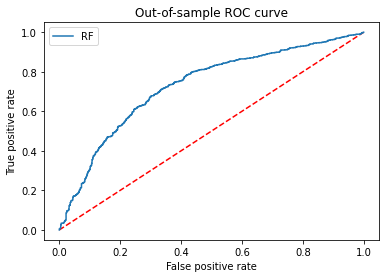

In [15]:
###############################################################################
# Out-of-Sample Testing
###############################################################################
# Extracting out-of-sample data (forward-test)
X_forward = X['2020-01-02':'2020-04-30']
y_forward = y['2020-01-02':'2020-04-30']

# Performance Metrics
y_pred_rf = algo.predict_proba(np.nan_to_num(X_forward))[:, 1]
y_pred = algo.predict(np.nan_to_num(X_forward))
fpr_rf, tpr_rf, _ = roc_curve(np.nan_to_num(y_forward), y_pred_rf)
print(classification_report(np.nan_to_num(y_forward), y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_forward, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_forward, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Out-of-sample ROC curve')
plt.legend(loc='best')
plt.show()

Start date,2020-01-03
End date,2020-04-30
Total months,4
,Backtest
Annual return,-12.4%
Cumulative returns,-4.4%
Annual volatility,19.3%
Sharpe ratio,-0.59
Calmar ratio,-0.89
Stability,0.01
Max drawdown,-13.9%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,13.91,2020-03-26,2020-04-20,NaT,NaN
1,7.42,2020-01-08,2020-03-09,2020-03-18,51
2,1.64,2020-03-23,2020-03-24,2020-03-25,3
3,0.01,2020-01-03,2020-01-06,2020-01-07,3
4,0.00,2020-01-03,2020-01-03,2020-01-03,1


Stress Events,mean,min,max
New Normal,-0.05%,-3.21%,4.35%


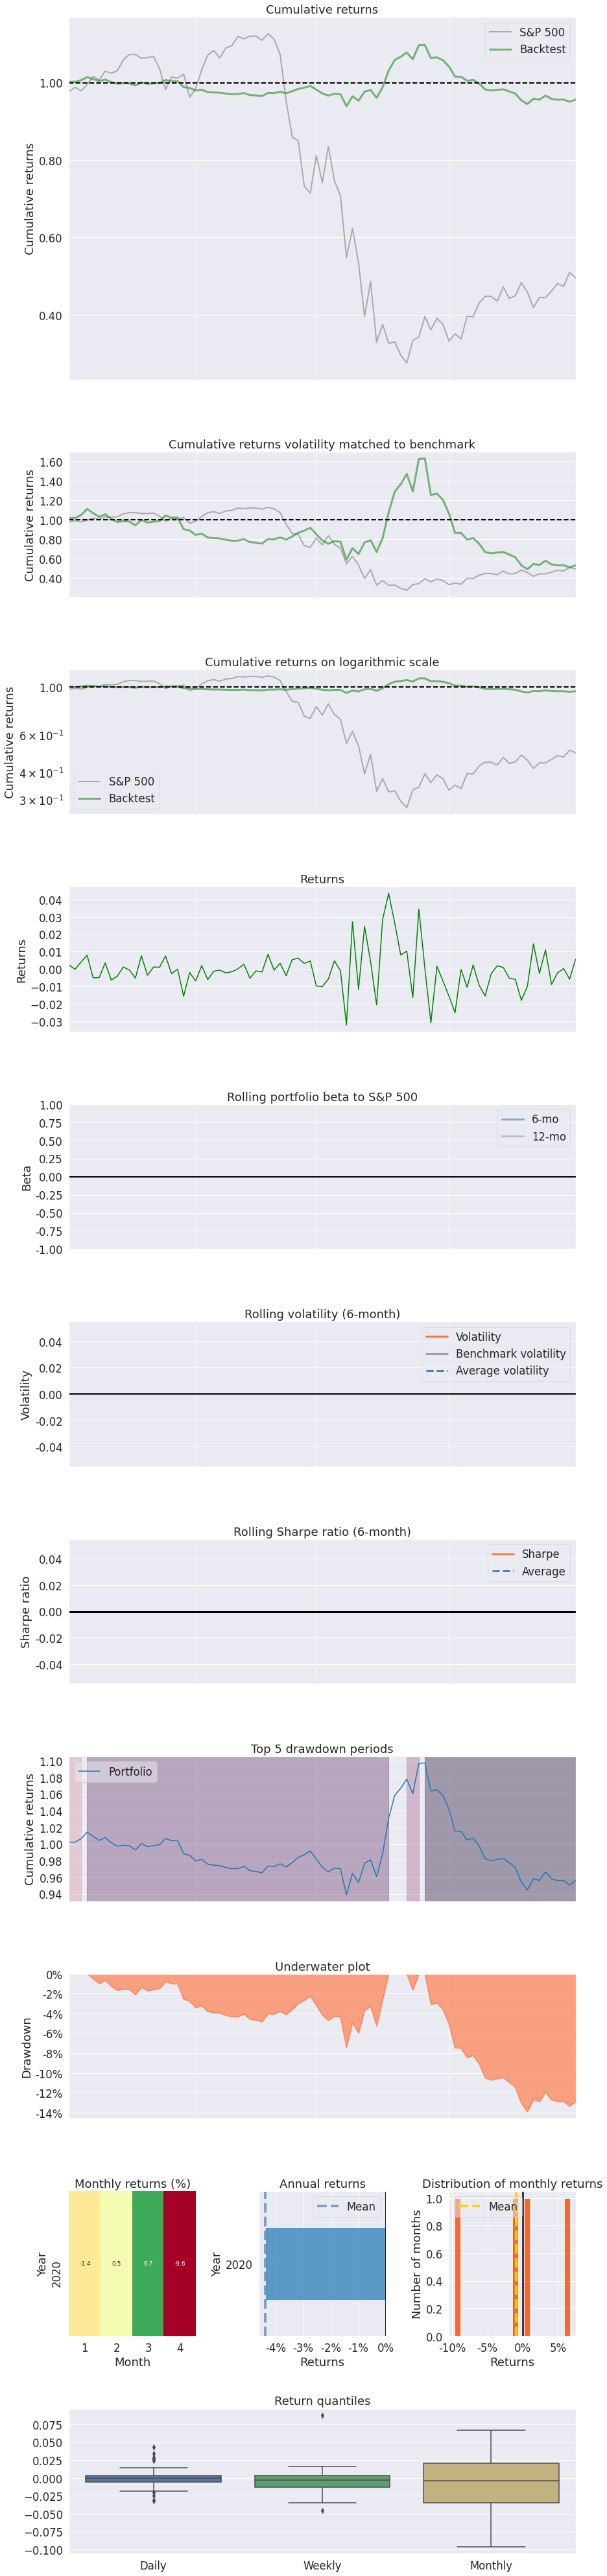

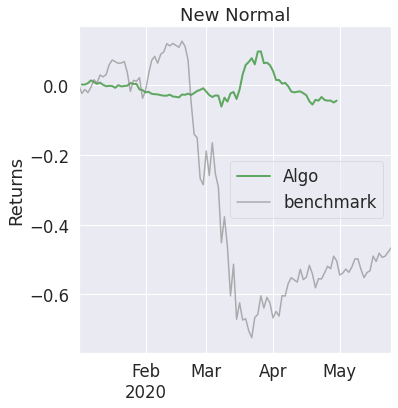

In [16]:
###############################################################################
# Out-of-Sample Trading Performance
###############################################################################

# getting benchmark data

sp500 = yf.Ticker("^GSPC")
bench = sp500.history(period='ytd')
bench['S&P 500'] =(bench['Close'].diff())*0.001
bench_ret = bench['S&P 500']

# Without meta-labeling

fwd_test_dates = X_forward.index

# Downsample to daily
prim_rets_test = labels.loc[fwd_test_dates, 'ret']
daily_rets_prim = get_daily_returns(prim_rets_test)

#pf.show_perf_stats(daily_rets_prim)
# pf.show_perf_stats(labels.loc[fwd_test_dates, 'ret'])
pf.create_full_tear_sheet(daily_rets_prim, round_trips = False, benchmark_rets=bench_ret)

Start date,2020-01-03
End date,2020-04-30
Total months,4
,Backtest
Annual return,784.9%
Cumulative returns,108.6%
Annual volatility,22.2%
Sharpe ratio,9.96
Calmar ratio,576.56
Stability,0.86
Max drawdown,-1.4%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.36,2020-01-29,2020-01-30,2020-02-05,6
1,0.97,2020-04-08,2020-04-09,2020-04-13,4
2,0.70,2020-01-21,2020-01-22,2020-01-24,4
3,0.58,2020-04-23,2020-04-24,2020-04-27,3
4,0.57,2020-04-16,2020-04-17,2020-04-21,4


Stress Events,mean,min,max
New Normal,0.88%,-1.36%,6.13%


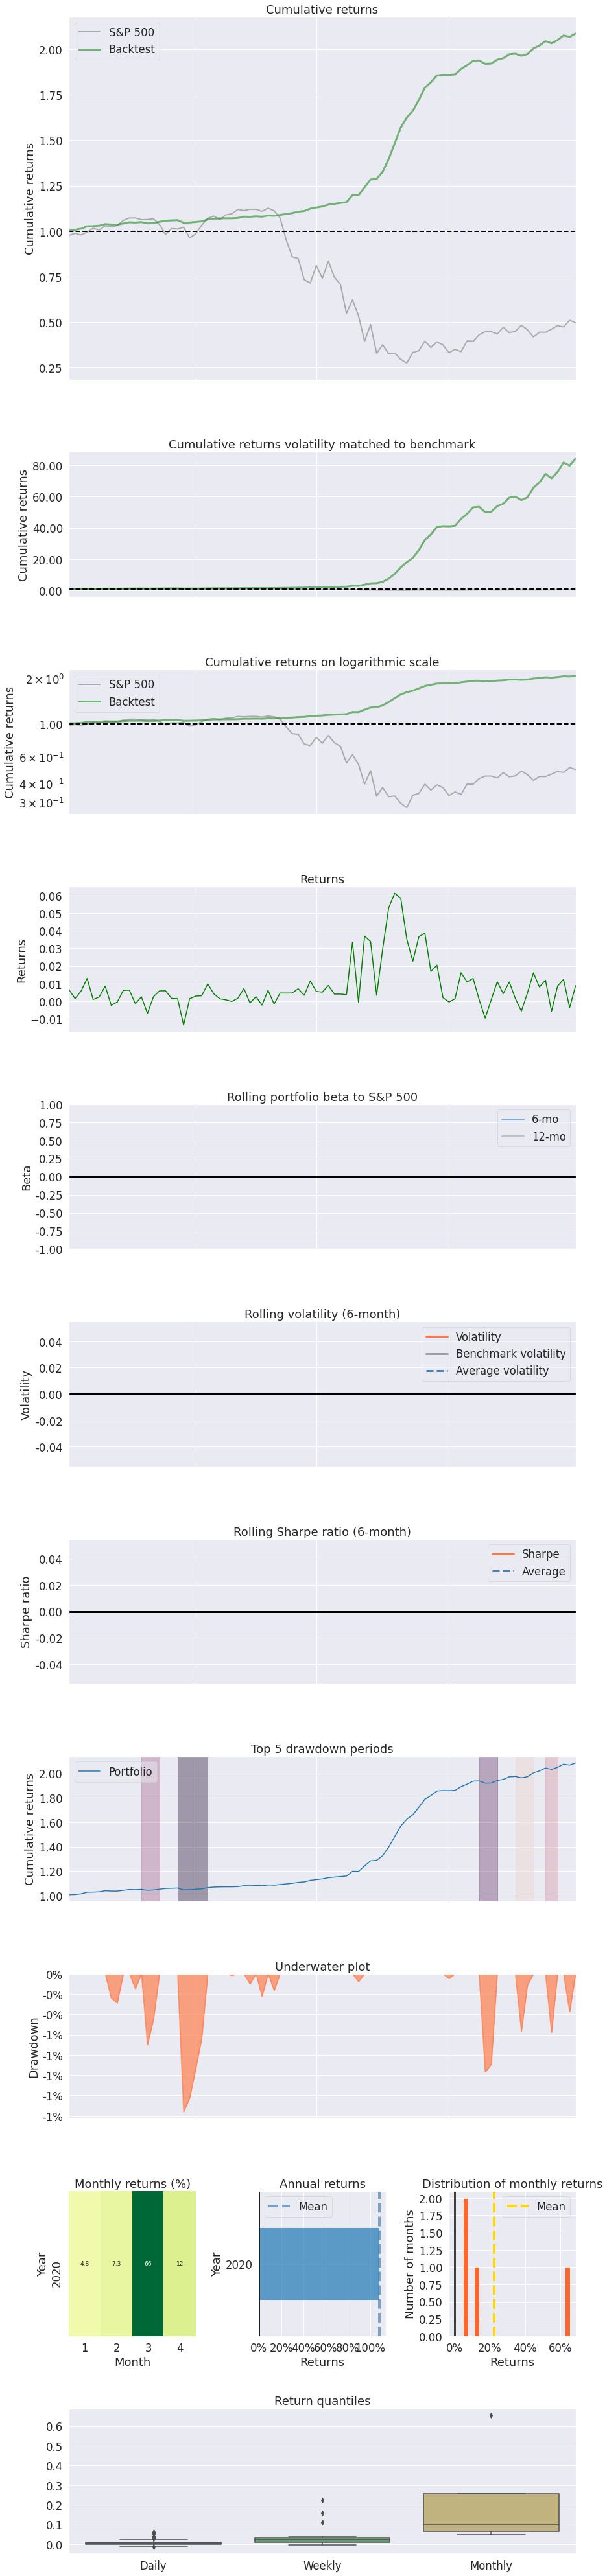

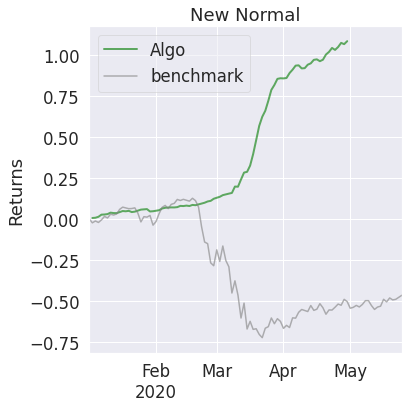

In [17]:
# With meta-labeling

warnings.filterwarnings("ignore")

meta_returns = labels.loc[fwd_test_dates, 'ret'] * y_pred
daily_rets_meta = get_daily_returns(meta_returns)

pf.create_full_tear_sheet(daily_rets_meta, round_trips = False, benchmark_rets=bench_ret)

Start date,2020-01-03
End date,2020-04-30
Total months,4
,Backtest
Annual return,512.6%
Cumulative returns,84.3%
Annual volatility,21.0%
Sharpe ratio,8.75
Calmar ratio,358.27
Stability,0.84
Max drawdown,-1.4%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.43,2020-01-29,2020-01-30,2020-02-05,6
1,1.19,2020-04-08,2020-04-09,2020-04-14,5
2,0.80,2020-01-21,2020-01-22,2020-01-27,5
3,0.71,2020-04-16,2020-04-17,2020-04-21,4
4,0.66,2020-04-23,2020-04-24,2020-04-27,3


Stress Events,mean,min,max
New Normal,0.73%,-1.43%,5.67%


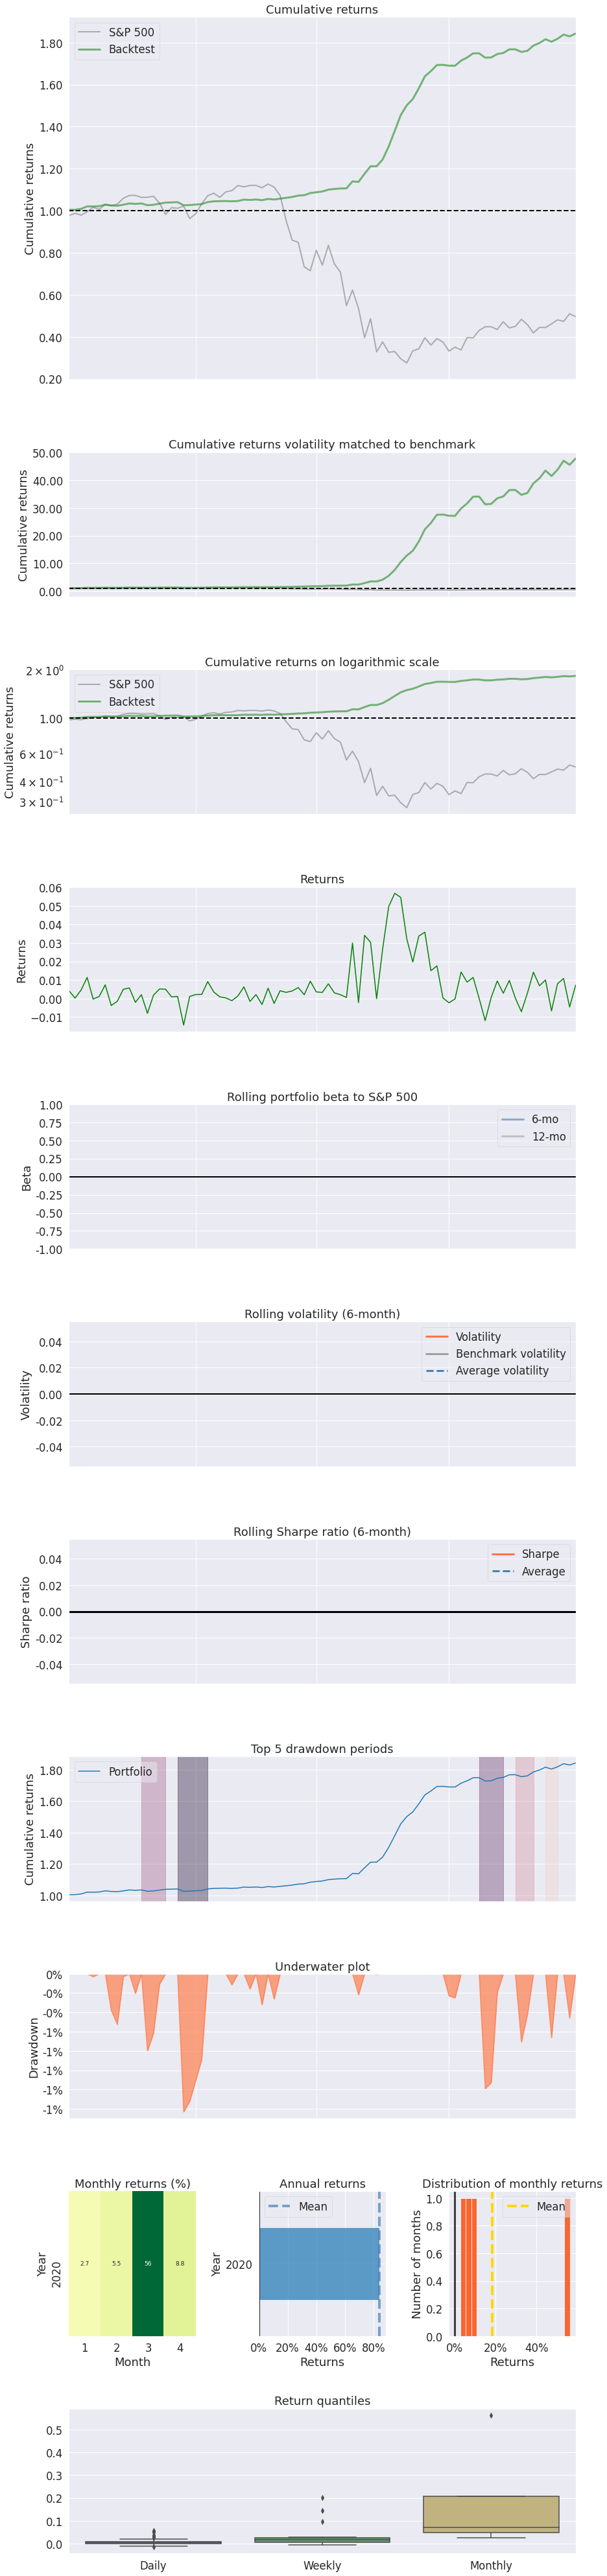

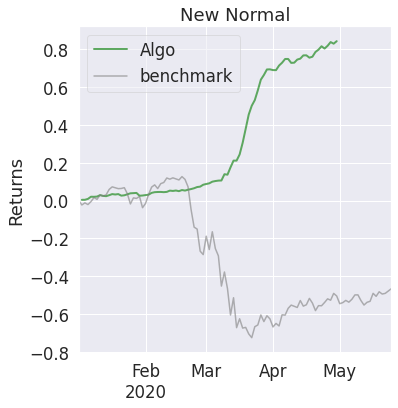

In [18]:
# "SIMULATION" (with meta-labeling, adjusted returns)
#labels_bckup = labels.copy()
commission = 0.00006
avg_spread = 0.00008


labels["net_ret"] = labels.ret-commission-avg_spread

meta_returns = labels.loc[fwd_test_dates, 'net_ret'] * y_pred
daily_rets_meta = get_daily_returns(meta_returns)

pf.create_full_tear_sheet(daily_rets_meta, round_trips = False, benchmark_rets=bench_ret)

# Addendum: Data structuring

This is the section for the analysis of different bar construction methods, as described in the capstone paper in chapters 2.2 and 3.1.

In [0]:
###############################################################################
# Data Structuring
###############################################################################
# Counting observations
rr = pd.read_csv('https://capital20.com/WQU_CapstoneData/GBPUSD_TickBar_500_Bid_2019.01.02_2020.05.13.csv')
rr.index = pd.to_datetime(rr['Time (UTC)'])
rr = rr.drop(['Time (UTC)', 'EndTime'], axis=1)
rr['2019-01-02':'2020-04-30']
rr_tot = len(rr.index)
rr_ins = len(rr['2019-01-02':'2019-12-31'].index)
rr_oos = int(rr_tot-rr_ins)
rr_train = int(rr_ins*0.8)
rr_test = int(rr_ins*0.2)

print('Number of data points:')
print('Total: %.3f' % (rr_tot))
print('Train set: %.3f' % (rr_train))
print('Validation set: %.3f' % (rr_test))
print('OOS Test set: %.3f' % (rr_oos))

Number of data points:
Total: 87026.000
Train set: 48955.000
Validation set: 12238.000
OOS Test set: 25832.000


In [0]:
ticks = pd.read_csv('https://capital20.com/WQU_CapstoneData/GBPUSD_Ticks_2020.05.01_2020.05.19.csv')

In [0]:
ticks0 = pd.DataFrame(columns = ['date_time', 'price', 'volume'])
ticks0['date_time'] = ticks['Time (UTC)']
ticks0['price'] = ticks['Bid']
ticks0['volume'] = ticks['BidVolume']

In [0]:
# Creating custom bars
from mlfinlab.data_structures import standard_data_structures

tick_bars = standard_data_structures.get_tick_bars(ticks0, threshold=500, batch_size=1000000, verbose=False)
volume_bars = standard_data_structures.get_volume_bars(ticks0, threshold=1000, batch_size=1000000, verbose=False)
dollar_bars = standard_data_structures.get_volume_bars(ticks0, threshold=900, batch_size=1000000, verbose=False)

In [0]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

In [0]:
time_bars = pd.read_csv('https://capital20.com/WQU_CapstoneData/GBPUSD_5Mins_Bid_2020.05.01_2020.05.19.csv', index_col='Time (UTC)')

time_bars.index = pd.to_datetime(time_bars.index)
tick_bars.index = pd.to_datetime(tick_bars.index)
volume_bars.index = pd.to_datetime(volume_bars.index)
dollar_bars.index = pd.to_datetime(dollar_bars.index)

In [0]:
###############################################################################
# AC Analysis
###############################################################################
time_returns = np.log(time_bars['Close']).diff().dropna()
tick_returns = np.log(tick_bars['close']).diff().dropna()
volume_returns = np.log(volume_bars['close']).diff().dropna()
dollar_returns = np.log(dollar_bars['close']).diff().dropna()

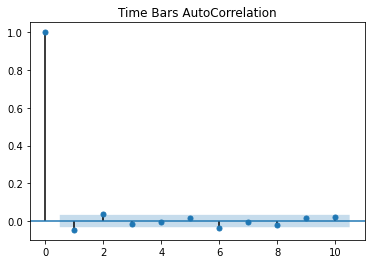

In [0]:
plot_acf(time_returns, lags=10)
plt.title('Time Bars AutoCorrelation')
plt.show()

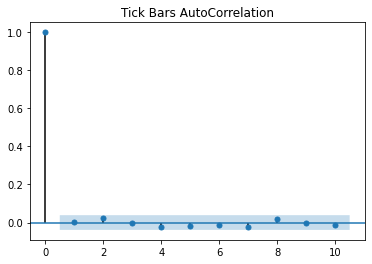

In [0]:
plot_acf(tick_returns, lags=10)
plt.title('Tick Bars AutoCorrelation')
plt.show()

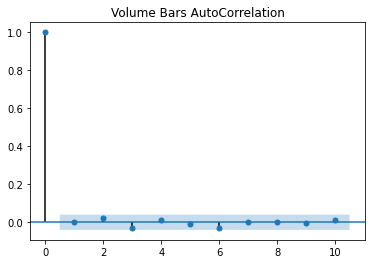

In [0]:
plot_acf(volume_returns, lags=10)
plt.title('Volume Bars AutoCorrelation')
plt.show()

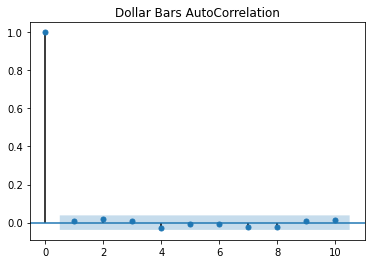

In [0]:
plot_acf(dollar_returns, lags=10)
plt.title('Dollar Bars AutoCorrelation')
plt.show()

In [0]:
###############################################################################
# Jarque-Bera Test, Normality
###############################################################################
from scipy import stats

print ('Test Statistics:')
print ('Time:', '\t', stats.jarque_bera(time_returns))
print ('Tick:', '\t', stats.jarque_bera(tick_returns))
print ('Volume:', stats.jarque_bera(volume_returns))
print ('Dollar:', stats.jarque_bera(dollar_returns))

Test Statistics:
Time: 	 (4010.895460375833, 0.0)
Tick: 	 (64.80119825030046, 8.43769498715119e-15)
Volume: (125.11752372184269, 0.0)
Dollar: (70.45158339715121, 5.551115123125783e-16)


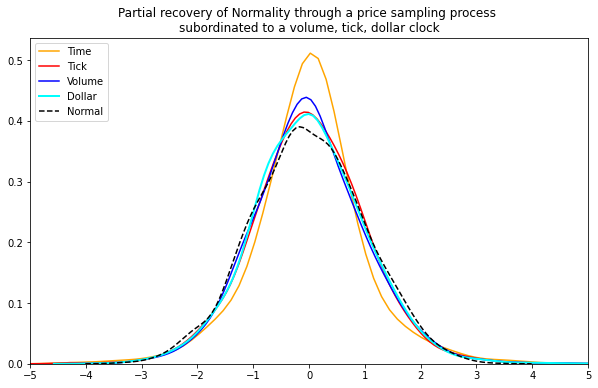

In [0]:
# Calculate the differences
time_diff = time_returns
tick_diff = tick_returns
volume_diff = volume_returns
dollar_diff = dollar_returns

# Standardize the data
time_standard = (time_diff - time_diff.mean()) / time_diff.std()
tick_standard = (tick_diff - tick_diff.mean()) / tick_diff.std()
volume_standard = (volume_diff - volume_diff.mean()) / volume_diff.std()
dollar_standard = (dollar_diff - dollar_diff.mean()) / dollar_diff.std()

# Plot the Distributions
plt.figure(figsize=(10,6))
sns.kdeplot(time_standard, label="Time", bw=0.30, color='orange')
sns.kdeplot(tick_standard, label="Tick", bw=0.25, color='red')
sns.kdeplot(volume_standard, label="Volume", bw=0.25, color='blue')
sns.kdeplot(dollar_standard, label="Dollar", bw=0.25, linewidth=2, color='cyan')

sns.kdeplot(np.random.normal(size=len(volume_returns)), label="Normal", color='black', linestyle="--")

plt.xticks(range(-5, 6))
plt.legend(loc='upper left')
plt.title('Partial recovery of Normality through a price sampling process \nsubordinated to a volume, tick, dollar clock',
          loc='center')
plt.xlim(-5, 5)
plt.show()